In [32]:
!pip install pyspark

In [33]:
import pyspark

In [34]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Assginment').getOrCreate()
spark

In [35]:
df=spark.read.csv('hdfs://localhost:9000/data/TweetsDataset.csv',header=True)
df.show(5)

+--------------------+--------+--------------------+--------+---------+
|  tweet_date_created|tweet_id|          tweet_text|language|sentiment|
+--------------------+--------+--------------------+--------+---------+
|2018-06-30T19:26:...|1.01E+18|I vote #BernardoC...|      en|  NEUTRAL|
|2018-08-12T14:23:...|1.03E+18|When is your firs...|      en|  NEUTRAL|
|2018-07-17T10:50:...|1.02E+18|#Cristiano You ne...|      en|  NEUTRAL|
| 2018-06-08T15:20:06|1.01E+18|#youngy18 #Englan...|      en| POSITIVE|
|2018-07-28T17:25:...|1.02E+18|#LFC #officialAL2...|      en|  NEUTRAL|
+--------------------+--------+--------------------+--------+---------+
only showing top 5 rows



In [36]:
print("Number of duplicates=",df.count()-df.drop_duplicates().count())

Number of duplicates= 1023944


Drop the duplicates

In [37]:
df=df.drop_duplicates()
count=df.count()
print(count)

6592620


In [38]:
df=df.drop('language')
df.show(5)

+--------------------+--------+--------------------+---------+
|  tweet_date_created|tweet_id|          tweet_text|sentiment|
+--------------------+--------+--------------------+---------+
|2018-07-20T19:46:...|1.02E+18|#leeabellis #andr...|  NEUTRAL|
|2018-09-12T20:32:...|1.04E+18|#Paschal_MUFC #LF...|  NEUTRAL|
| 2018-06-02T12:59:17|1.00E+18|#jnoahmorgan #hen...|  NEUTRAL|
|2018-07-24T08:30:...|1.02E+18|#HenrikhMkh #Auba...| POSITIVE|
|2018-07-10T22:47:...|1.02E+18|#Howmanyroads1 #b...|  NEUTRAL|
+--------------------+--------+--------------------+---------+
only showing top 5 rows



Clean date

In [39]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf,expr,col
df=df.withColumn("tweet_date_created",col('tweet_date_created').cast('string'))
df.printSchema()

root
 |-- tweet_date_created: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [40]:
def cleanDate(date):
  date = date.split("T")[0]
  return (date)
cleanDateFunction=udf(lambda x:cleanDate(x),StringType())
df=df.withColumn("tweet_date_created",cleanDateFunction(df.tweet_date_created))
df.show(5)

+------------------+--------+--------------------+---------+
|tweet_date_created|tweet_id|          tweet_text|sentiment|
+------------------+--------+--------------------+---------+
|        2018-07-20|1.02E+18|#leeabellis #andr...|  NEUTRAL|
|        2018-09-12|1.04E+18|#Paschal_MUFC #LF...|  NEUTRAL|
|        2018-06-02|1.00E+18|#jnoahmorgan #hen...|  NEUTRAL|
|        2018-07-24|1.02E+18|#HenrikhMkh #Auba...| POSITIVE|
|        2018-07-10|1.02E+18|#Howmanyroads1 #b...|  NEUTRAL|
+------------------+--------+--------------------+---------+
only showing top 5 rows



Remove retweets

In [41]:
print("Before=",count)

Before= 6592620


In [42]:
df=df.filter(~df.tweet_text.contains('Retweeted'))
df.show(5)

+------------------+--------+--------------------+---------+
|tweet_date_created|tweet_id|          tweet_text|sentiment|
+------------------+--------+--------------------+---------+
|        2018-07-20|1.02E+18|#leeabellis #andr...|  NEUTRAL|
|        2018-09-12|1.04E+18|#Paschal_MUFC #LF...|  NEUTRAL|
|        2018-06-02|1.00E+18|#jnoahmorgan #hen...|  NEUTRAL|
|        2018-07-24|1.02E+18|#HenrikhMkh #Auba...| POSITIVE|
|        2018-07-10|1.02E+18|#Howmanyroads1 #b...|  NEUTRAL|
+------------------+--------+--------------------+---------+
only showing top 5 rows



In [43]:
count=df.count()
print("After=",count)

After= 6590377


Remove irrelevent tweets

In [44]:
df=df.filter("Sentiment like '%POSITIVE%' or Sentiment like '%NEGATIVE%' or Sentiment like '%NEUTRAL%'")
df=df.filter(~df.tweet_text.contains('http'))
count=df.count()
print(count)

6234684


Realized you dont need tweet_Id, tweet_date as well

In [45]:
df=df.drop('tweet_id')
df.show(5)

+------------------+--------------------+---------+
|tweet_date_created|          tweet_text|sentiment|
+------------------+--------------------+---------+
|        2018-07-20|#leeabellis #andr...|  NEUTRAL|
|        2018-09-12|#Paschal_MUFC #LF...|  NEUTRAL|
|        2018-06-02|#jnoahmorgan #hen...|  NEUTRAL|
|        2018-07-24|#HenrikhMkh #Auba...| POSITIVE|
|        2018-07-10|#Howmanyroads1 #b...|  NEUTRAL|
+------------------+--------------------+---------+
only showing top 5 rows



Removing Stop words and tokenize

In [46]:
from pyspark.ml.feature import StopWordsRemover

def tokenizeText(text):
  lst=[]
  text=text.split(' ')
  for words in text:
    if words.find('@')==-1:
      if words.find('#')==-1:
        lst.append(words)
  return lst
tokenizeTextFunction=udf(lambda x: tokenizeText(x),ArrayType(StringType()))
df=df.withColumn("SplittedWords",tokenizeTextFunction(df.tweet_text))
df.show()

stopwordsremover=StopWordsRemover(inputCol="SplittedWords",outputCol="SplittedWordsNew")
df=stopwordsremover.transform(df)
df.show()

+------------------+--------------------+---------+--------------------+
|tweet_date_created|          tweet_text|sentiment|       SplittedWords|
+------------------+--------------------+---------+--------------------+
|        2018-07-20|#leeabellis #andr...|  NEUTRAL|[How, is, he, a, ...|
|        2018-09-12|#Paschal_MUFC #LF...|  NEUTRAL|[How, did, you, m...|
|        2018-06-02|#jnoahmorgan #hen...|  NEUTRAL|[I, just, apologi...|
|        2018-07-24|#HenrikhMkh #Auba...| POSITIVE|[Good, luck, this...|
|        2018-07-10|#Howmanyroads1 #b...|  NEUTRAL|[I, believe, he, ...|
|        2018-07-10|Every starter for...|  NEUTRAL|[Every, starter, ...|
|        2018-07-23|#chazaustin10 #CA...|  NEUTRAL|[Charkie10, ?...,...|
|        2018-06-16|#D_DeGea #BumperG...|  NEUTRAL|[Come, on, Baxter...|
|        2018-05-27|#MarkMoraghan #18...|  NEUTRAL|[I, will, fight, ...|
|        2018-05-24|#andresiniesta8 M...|  NEUTRAL|[Muchas, gracias,...|
|        2018-06-10|#GoloFutbol #MrDt...|  NEUTRAL|

In [47]:
df=df.drop('SplittedWords')

In [48]:
!pip install nltk

stemming and lemmatization of data

In [49]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [50]:
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

def stem_words(words):
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

stemming_udf = udf(stem_words, ArrayType(StringType()))
lemmatization_udf = udf(lemmatize_words, ArrayType(StringType()))

df = df.withColumn('stemmed_words', stemming_udf('SplittedWordsNew'))
df = df.withColumn('lemmatized_words', lemmatization_udf('stemmed_words'))

df.show()

+------------------+--------------------+---------+--------------------+--------------------+--------------------+
|tweet_date_created|          tweet_text|sentiment|    SplittedWordsNew|       stemmed_words|    lemmatized_words|
+------------------+--------------------+---------+--------------------+--------------------+--------------------+
|        2018-07-20|#leeabellis #andr...|  NEUTRAL|[big, loss?, bare...|[big, loss?, bare...|[big, loss?, bare...|
|        2018-09-12|#Paschal_MUFC #LF...|  NEUTRAL|[mean, country, b...|[mean, countri, b...|[mean, countri, b...|
|        2018-06-02|#jnoahmorgan #hen...|  NEUTRAL|[apologize, ?., I...|[apolog, ?., i ll...|[apolog, ?., i ll...|
|        2018-07-24|#HenrikhMkh #Auba...| POSITIVE|[Good, luck, seas...|[good, luck, seas...|[good, luck, seas...|
|        2018-07-10|#Howmanyroads1 #b...|  NEUTRAL|[believe, verball...|[believ, verbal, ...|[believ, verbal, ...|
|        2018-07-10|Every starter for...|  NEUTRAL|[Every, starter, ...|[everi, 

Handling emojis (i forgot bout that earlier)

In [51]:
import re

def removeEmojis(words):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return [emoji_pattern.sub(r'', word) for word in words]

removeEmojisFunction = udf(removeEmojis, ArrayType(StringType()))

df = df.withColumn('no_emojis', removeEmojisFunction(df.lemmatized_words))
df.show(5)

+------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|tweet_date_created|          tweet_text|sentiment|    SplittedWordsNew|       stemmed_words|    lemmatized_words|           no_emojis|
+------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|        2018-07-20|#leeabellis #andr...|  NEUTRAL|[big, loss?, bare...|[big, loss?, bare...|[big, loss?, bare...|[big, loss?, bare...|
|        2018-09-12|#Paschal_MUFC #LF...|  NEUTRAL|[mean, country, b...|[mean, countri, b...|[mean, countri, b...|[mean, countri, b...|
|        2018-06-02|#jnoahmorgan #hen...|  NEUTRAL|[apologize, ?., I...|[apolog, ?., i ll...|[apolog, ?., i ll...|[apolog, ?., ill,...|
|        2018-07-24|#HenrikhMkh #Auba...| POSITIVE|[Good, luck, seas...|[good, luck, seas...|[good, luck, seas...|[good, luck, seas...|
|        2018-07-10|#Howmanyroads1 #b...|  NEUTR

#Sentiment Analysis

Using pandas dataframe

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
pandas_df=df.toPandas()

pandas_df['no_emojis'] = pandas_df['no_emojis'].apply(' '.join)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(pandas_df['no_emojis'])
X_train, X_test, y_train, y_test = train_test_split(X, pandas_df['sentiment'], test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy=",accuracy)

accuracy= 0.7785016286644951


Using pyspark ML

In [53]:
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
df = df.drop('features', 'label')

indexer = StringIndexer(inputCol='sentiment', outputCol='label')
df = indexer.fit(df).transform(df)
vectorizer = CountVectorizer(inputCol='no_emojis', outputCol='features')
model = vectorizer.fit(df)
df = model.transform(df)

train, test = df.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(labelCol='label')
lr_model = lr.fit(train)

predictions = lr_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# rdd so that we can use MulticlassMetrics
predictionAndLabels = predictions.select(['prediction', 'label']).rdd

metrics = MulticlassMetrics(predictionAndLabels)
precision = metrics.weightedPrecision
recall = metrics.weightedRecall
f1Score = metrics.weightedFMeasure()

print("accuracy=", accuracy)
print("precision=", precision)
print("recall=", recall)
print("F1-score=", f1Score)

df = df.drop('features', 'label')

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


accuracy= 0.7423076923076923
precision= 0.7309895833333334
recall= 0.7423076923076923
F1-score= 0.7316461468308254


Using Naive Bayes

In [54]:
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
df = df.drop('features', 'label')

indexer = StringIndexer(inputCol='sentiment', outputCol='label')
df = indexer.fit(df).transform(df)
vectorizer = CountVectorizer(inputCol='no_emojis', outputCol='features')
model = vectorizer.fit(df)
df = model.transform(df)

train, test = df.randomSplit([0.8, 0.2], seed=42)

nb = NaiveBayes(labelCol='label')
nb_model = nb.fit(train)

predictions = nb_model.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# we convert into rdd so that we may be able to use MulticlassMetrics
predictionAndLabels = predictions.select(['prediction', 'label']).rdd

metrics = MulticlassMetrics(predictionAndLabels)
precision = metrics.weightedPrecision
recall = metrics.weightedRecall
f1Score = metrics.weightedFMeasure()

print("accuracy=", accuracy)
print("precision=", precision)
print("recall=", recall)
print("F1-score=", f1Score)

df = df.drop('features', 'label')

accuracy= 0.6730769230769231
precision= 0.674421052631579
recall= 0.6730769230769231
F1-score= 0.6727576136837714


In [55]:
from pyspark.sql.functions import explode
df.createOrReplaceTempView("temp")
# we were told to use the sql 
sentiment_distribution = spark.sql("SELECT sentiment, COUNT(*) as count FROM temp GROUP BY sentiment")
sentiment_distribution.show()

keywords = df.select(explode(df.no_emojis).alias("keyword"))
top_keywords = keywords.groupBy("keyword").count().orderBy("count",ascending=False).limit(10)
top_keywords.show()

+---------+-------+
|sentiment|  count|
+---------+-------+
| POSITIVE| 668516|
| NEGATIVE| 264996|
|  NEUTRAL|2502936|
+---------+-------+

+-------+-------+
|keyword|  count|
+-------+-------+
|     go| 201704|
|   play| 150039|
|      u| 702529|
|   goat| 417830|
| player| 769053|
|   team| 450781|
|   well| 350364|
|    get| 500301|
|   goal|1210754|
|    won|  39133|
+-------+-------+



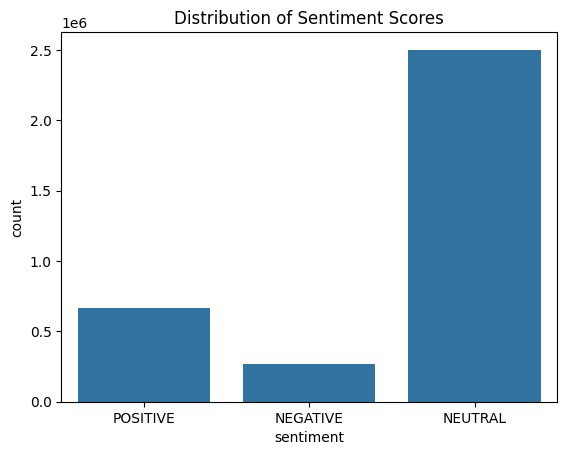

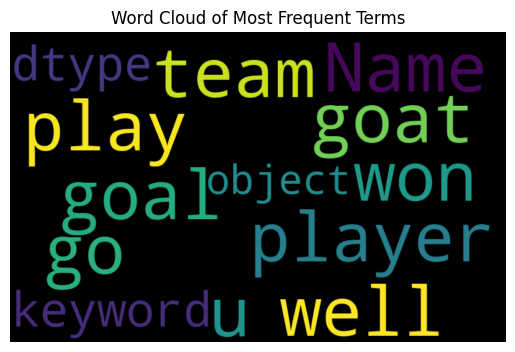

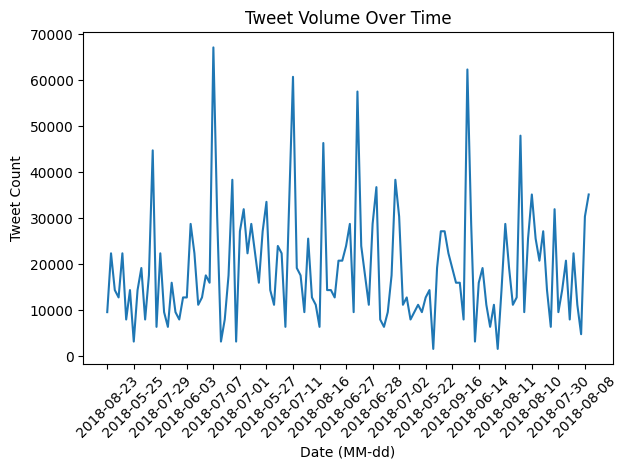

In [56]:
from pyspark.sql.functions import explode, to_date
from pyspark.sql.types import DateType
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# we change the datatype for the date col
df = df.withColumn("tweet_date_created", to_date(df.tweet_date_created, "yyyy-MM-dd"))


sentiment_pd = sentiment_distribution.toPandas()
sns.barplot(x='sentiment', y='count', data=sentiment_pd)
plt.title('Distribution of Sentiment Scores')
plt.show()


keywords = df.select(explode(df.no_emojis).alias("keyword"))
top_keywords_pd = top_keywords.toPandas()
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top_keywords_pd['keyword']))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()


tweet_volume = spark.sql("SELECT tweet_date_created, COUNT(*) as count FROM temp GROUP BY tweet_date_created")
tweet_volume_pd=tweet_volume.toPandas()
sns.lineplot(x='tweet_date_created', y='count', data=tweet_volume_pd)
plt.title('Tweet Volume Over Time')
plt.xlabel('Date (MM-dd)')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)

# show only 7th labels (every 7th label 1,7,14,..)
n = 7
plt.xticks(range(0, len(tweet_volume_pd), n), tweet_volume_pd['tweet_date_created'][::n])
plt.tight_layout()
plt.show()

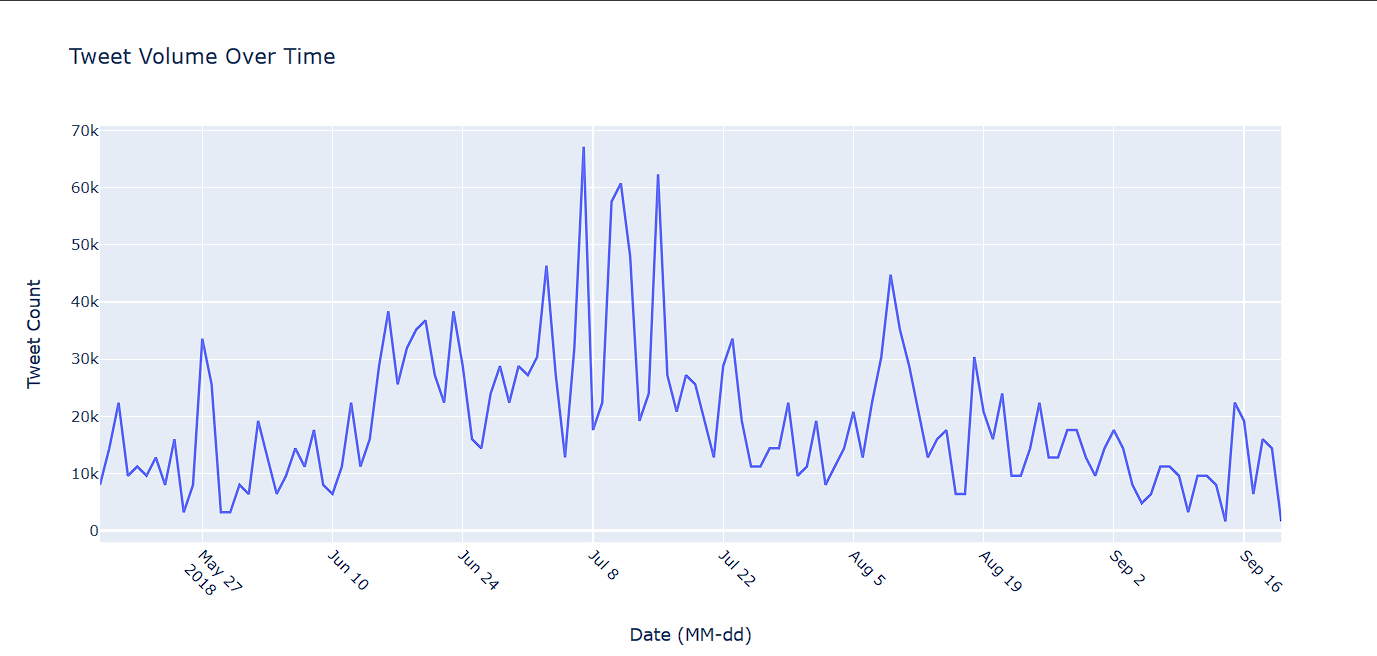

In [63]:
import plotly.express as px

tweet_volume = spark.sql("SELECT tweet_date_created, COUNT(*) as count FROM temp GROUP BY tweet_date_created")
tweet_volume_pd = tweet_volume.toPandas()
#to avoid the jumping of values
tweet_volume_pd.sort_values(by='tweet_date_created', inplace=True)

fig = px.line(tweet_volume_pd, x='tweet_date_created', y='count', title='Tweet Volume Over Time')
fig.update_xaxes(title_text='Date (MM-dd)', tickangle=45)
fig.update_yaxes(title_text='Tweet Count')
fig.show()



#as the picture was not opening by itself i have taken a screenshot and attached with it
from IPython.display import Image
Image(filename='Screenshot 2024-04-27 005744.png')


In [57]:
keywords = df.select(df.sentiment, explode(df.no_emojis).alias("keyword"))
top_keywords = keywords.groupBy("sentiment", "keyword").count().orderBy("count",ascending=False)
top_keywords.show(5)

+---------+-------+--------+
|sentiment|keyword|   count|
+---------+-------+--------+
| POSITIVE|   goal| 1210754|
|  NEUTRAL| player|  769053|
|  NEUTRAL|      u|  702529|
| POSITIVE|    get|  500301|
| POSITIVE|   team|  450781|
+---------+-------+--------+
only showing top 5 rows

